<a href="https://colab.research.google.com/github/blufzzz/Discrete-Curvature-Graph-Classification/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# colab setting
!pip install GraphRicciCurvature

import networkx as nx
import numpy as np
import math
import importlib
from IPython.display import clear_output
from IPython.core.debugger import set_trace

from tqdm import tqdm_notebook

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
clear_output()

In [0]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric
clear_output()

# CurvConv architecture

In [0]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Sequential as seq, Parameter,LeakyReLU,init,Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax, degree, add_self_loops, remove_self_loops
from torch_geometric.nn import GCNConv, EdgeConv, ECConv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_=torch.manual_seed(42)

In [0]:
class curvGN(MessagePassing):
    def __init__(self, in_channels, out_channels, w_mul=None, bias=True):
        super(curvGN, self).__init__(aggr='add')
        # self.w_mul = w_mul
        self.lin = Linear(in_channels, out_channels)
        widths = [1, out_channels]
        self.w_mlp_out = create_wmlp(widths, out_channels, True)

    def forward(self, x, edge_index, w_mul):
        x = self.lin(x)
        out_weight = self.w_mlp_out(w_mul)
        out_weight = softmax(out_weight, edge_index[0])
        return self.propagate(edge_index,  x=x, out_weight=out_weight), out_weight

    def message(self, x_j, out_weight):
        return out_weight*x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 5: Return new node embeddings.
        return aggr_out

def create_wmlp(widths, nfeato, lbias):
    mlp_modules=[]
    for k in range(len(widths)-1):
        mlp_modules.append(Linear(widths[k], widths[k+1], bias=False))
        mlp_modules.append(LeakyReLU(0.2, True))
    mlp_modules.append(Linear(widths[len(widths)-1], nfeato, bias=lbias))

    return seq(*mlp_modules)


In [0]:
class NetСurv(torch.nn.Module):
    def __init__(self, num_features, num_classes, w_mul=None, hidden=64):
        '''
        w_mul - curvatures
        '''
        super(NetСurv, self).__init__()

        self.conv1 = curvGN(num_features, hidden, w_mul=w_mul)
        self.conv2 = curvGN(hidden, num_classes, w_mul=w_mul)

    def forward(self, data, w_mul):
        x, edge_index = data.x, data.edge_index

        x, _ = self.conv1(x, edge_index, w_mul)
        x = F.elu(x)
        x = F.dropout(x,training=self.training)
        x, _ = self.conv2(x, edge_index, w_mul)
        
        return F.log_softmax(x, dim=1)

class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=64):
        super(Net, self).__init__()

        self.conv1 = GCNConv(num_features, hidden)
        self.conv2 = GCNConv(hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    

In [0]:
def get_curvatures_tensor(data, ricci_curvatures):
    ricci_curvatures_tensor = torch.empty((data.num_edges,)).to(device)
    for i in range(data.num_edges):
        edge = data.edge_index[:,i].tolist()
        ricci = ricci_curvatures[tuple(edge)]
        ricci_curvatures_tensor[i] = ricci
    return ricci_curvatures_tensor      

In [0]:
def FormannCurvature(G):
    G = G.copy()
    # Edge Forman curvature
    for (v1, v2) in G.edges():
        if G.is_directed():
            v1_nbr = set(list(G.predecessors(v1)) + list(G.successors(v1)))
            v2_nbr = set(list(G.predecessors(v2)) + list(G.successors(v2)))
        else:
            v1_nbr = set(G.neighbors(v1))
            v1_nbr.remove(v2)
            v2_nbr = set(G.neighbors(v2))
            v2_nbr.remove(v1)
        face = v1_nbr & v2_nbr
        # G[v1][v2]["face"]=face
        prl_nbr = (v1_nbr | v2_nbr) - face
        # G[v1][v2]["prl_nbr"]=prl_nbr
        G[v1][v2]["formanCurvature"] = len(face) + 2 - len(prl_nbr)
        # logger.debug("Source: %s, target: %d, Forman-Ricci curvature = %f  " % (
        #     v1, v2, G[v1][v2]["formanCurvature"]))

    # Node Forman curvature
    for n in G.nodes():
        fcsum = 0  # sum of the neighbor Forman curvature
        if G.degree(n) != 0:
            for nbr in G.neighbors(n):
                if 'formanCurvature' in G[n][nbr]:
                    fcsum += G[n][nbr]['formanCurvature']

            # assign the node Forman curvature to be the average of node's adjacency edges
            G.nodes[n]['formanCurvature'] = fcsum / G.degree(n)

        # logger.debug("node %d, Forman Curvature = %f" % (n, G.nodes[n]['formanCurvature']))
    print("Forman curvature computation done.")
    return G


# Compare performance 

In [0]:
n_edges = []
times_olliver = []
times_formann = []

for n_nodes in tqdm_notebook(np.arange(2,30)):
    
    complete_graph = nx.complete_graph(n_nodes) 
    n_edges.append(complete_graph.number_of_edges())
    
    t1=time.time()
    orc = OllivierRicci(complete_graph, alpha=0.5, verbose="ERROR")
    _ = orc.compute_ricci_curvature()
    t2=time.time()
    times_olliver.append(t2-t1)

    t1=time.time()
    _=FormannCurvature(complete_graph)
    t2=time.time()
    times_formann.append(t2-t1)

clear_output()    

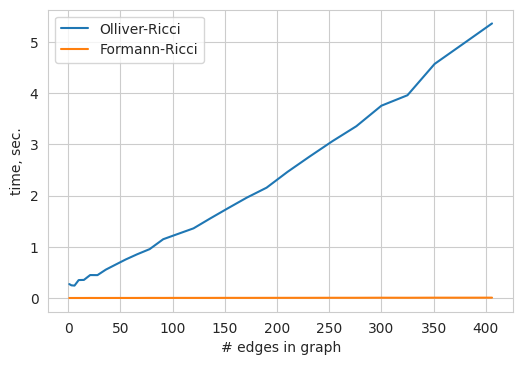

In [77]:
plt.figure(dpi=100)
plt.plot(n_edges,times_olliver, label='Olliver-Ricci')
plt.plot(n_edges,times_formann, label='Formann-Ricci')
plt.xlabel('# edges in graph')
plt.ylabel('time, sec.')
plt.legend()
plt.show()


# Dataset

In [0]:
from torch_geometric.datasets import Planetoid, Amazon, Coauthor
from torch_geometric.utils.convert import from_networkx, to_networkx

datasets = {
            'Amazon-Computer' : Amazon(root='/tmp/Amazon', name='Computers'),
            'Cora':Planetoid(root='/tmp/Cora',  name='Cora'),
            'CiteSeer':Planetoid(root='/tmp/CiteSeer', name='CiteSeer'),
            'PubMed':Planetoid(root='/tmp/PubMed', name='PubMed'),
}

dataset = datasets['Cora']
num_features = dataset.num_features
num_classes = dataset.num_classes

data = dataset[0]
assert hasattr(data, 'test_mask') or hasattr(data, 'train_mask')
data_nx = to_networkx(data,  node_attrs='x')
     

In [84]:
edge_weight_types = ['one', 'euclidean', 'manhattan']
edge_weight_type = 'one'

for edge in tqdm_notebook(data_nx.edges):
    if edge_weight_type == 'one':
        data_nx[edge[0]][edge[1]]['weight'] = 1.
    elif edge_weight_type == 'euclidean': 
        data_nx[edge[0]][edge[1]]['weight'] = torch.norm(torch.tensor(data_nx.nodes[edge[0]]['x']) -\
                                                         torch.tensor(data_nx.nodes[edge[1]]['x']), p=2 )
    elif edge_weight_type == 'manhattan': 
        data_nx[edge[0]][edge[1]]['weight'] = torch.norm(torch.tensor(data_nx.nodes[edge[0]]['x']) -\
                                                         torch.tensor(data_nx.nodes[edge[1]]['x']), p=1)  
    else:
      raise KeyError('Wrong `edge_weight_type`')   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Compute Olliver-Ricci: Yes
Forman curvature computation done.


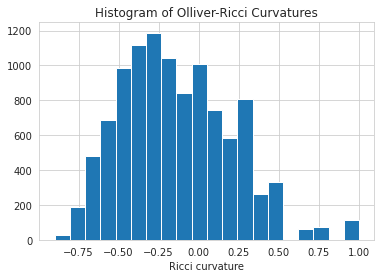

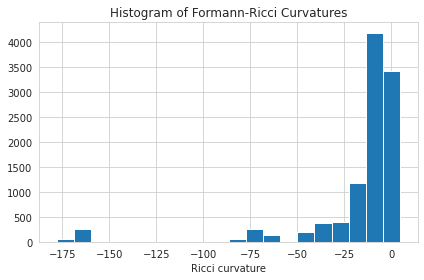

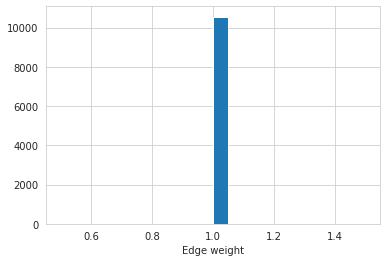

In [85]:
compute_olliver_ricci = data.edge_index.shape[1] < 20*1e3
print('Compute Olliver-Ricci:', 'Yes' if compute_olliver_ricci else 'No')

if compute_olliver_ricci:
    orc = OllivierRicci(data_nx, alpha=0.5, verbose="ERROR")
    _ = orc.compute_ricci_curvature()
    G_orc = orc.G.copy()
    ricci_curvatures_olliver = nx.get_edge_attributes(G_orc, "ricciCurvature")
    # plot
    plt.figure()
    plt.hist(ricci_curvatures_olliver.values(),bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Olliver-Ricci Curvatures")

G_frc = FormannCurvature(data_nx)
ricci_curvatures_formann = nx.get_edge_attributes(G_frc, 'formanCurvature')
# plot
plt.figure()
plt.hist(ricci_curvatures_formann.values(),bins=20)
plt.xlabel('Ricci curvature')
plt.title("Histogram of Formann-Ricci Curvatures")
plt.tight_layout()

edges_weights =  nx.get_edge_attributes(data_nx, "weight")
# plot
plt.figure()
plt.hist(edges_weights.values(),bins=20)
plt.xlabel('Edge weight')
plt.show()

# Training

In [0]:
def train_model(model, 
                dataset, 
                ricci_curvatures_tensor=None, 
                use_ricci_curvature=False,
                n_epochs=50):

    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    loss_history = []
    acc_history = []
    for epoch in tqdm_notebook(range(n_epochs)):
        
        model.train()
        optimizer.zero_grad()
        if use_ricci_curvature:
            out = model(data, ricci_curvatures_tensor)
        else:  
            out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        model.eval()
        pred = out
        _, pred = pred.max(dim=1)
        correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / data.test_mask.sum().item()
        acc_history.append(acc)

    return loss_history, acc_history

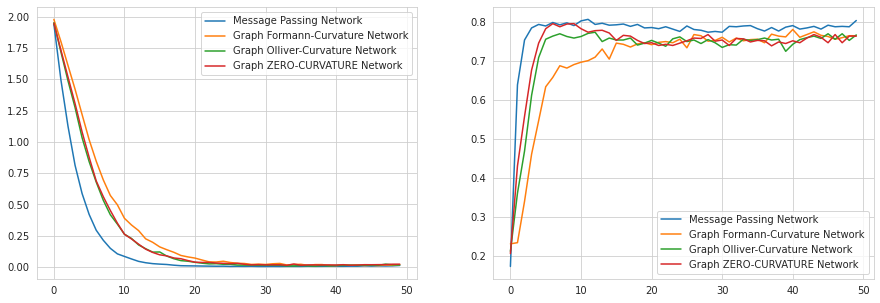

In [87]:
#################
# DEFINE MODELS #
#################
ricci_curvatures_formann_tensor = get_curvatures_tensor(data, ricci_curvatures_formann).unsqueeze(1)

if compute_olliver_ricci:
    ricci_curvatures_olliver_tensor = get_curvatures_tensor(data, ricci_curvatures_olliver).unsqueeze(1)
if edge_weight_type != 'one':
    edges_weights_tensor = get_curvatures_tensor(data, edges_weights).unsqueeze(1)

# edges-weights
if edge_weight_type != 'one':
    model_curv_edges = NetСurv(num_features, num_classes).to(device)
    out = model_curv_edges(data.to(device), edges_weights_tensor)

# oliver-ricci
if compute_olliver_ricci:
    model_curv_olliver = NetСurv(num_features, num_classes).to(device)
    out = model_curv_olliver(data.to(device), ricci_curvatures_olliver_tensor)

# formann-ricci
model_curv_formann = NetСurv(num_features, num_classes).to(device)
out = model_curv_formann(data.to(device), ricci_curvatures_formann_tensor)

# zero curvatures
model_curv_zeros = NetСurv(num_features, num_classes).to(device)
zeros_curvatures = torch.zeros_like(ricci_curvatures_formann_tensor)
out = model_curv_zeros(data.to(device), zeros_curvatures)

# message-passing
model = Net(num_features, num_classes).to(device)
out = model(data.to(device))

################
# TRAIN MODELS #
################
loss_hist, acc_history = train_model(model, dataset, use_ricci_curvature=False)
loss_hist_curv_forman, acc_history_curv_formann = train_model(model_curv_formann,
                                                      dataset, 
                                                      ricci_curvatures_formann_tensor, 
                                                      use_ricci_curvature=True)
if compute_olliver_ricci:
    loss_hist_curv_olliver, acc_history_curv_olliver = train_model(model_curv_olliver, 
                                                          dataset, 
                                                          ricci_curvatures_olliver_tensor, 
                                                          use_ricci_curvature=True)
loss_hist_curv_zeros, acc_history_curv_zeros = train_model(model_curv_zeros,
                                                          dataset, 
                                                          zeros_curvatures,
                                                          use_ricci_curvature=True)
if edge_weight_type != 'one':
    loss_hist_curv_edges, acc_history_curv_edges = train_model(model_curv_edges,
                                                              dataset, 
                                                              edges_weights_tensor,
                                                              use_ricci_curvature=True)

clear_output()


################
# PLOT RESULTS #
################
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(loss_hist, label = 'Message Passing Network')
ax1.plot(loss_hist_curv_forman, label = 'Graph Formann-Curvature Network')
if compute_olliver_ricci:
    ax1.plot(loss_hist_curv_olliver, label = 'Graph Olliver-Curvature Network')
ax1.plot(loss_hist_curv_zeros, label = 'Graph ZERO-CURVATURE Network')
if edge_weight_type != 'one':
    ax1.plot(loss_hist_curv_edges, label = 'Graph Edge-Weight-Curv Network')


ax2.plot(acc_history, label = 'Message Passing Network')
ax2.plot(acc_history_curv_formann, label = 'Graph Formann-Curvature Network')
if compute_olliver_ricci:
    ax2.plot(acc_history_curv_olliver, label = 'Graph Olliver-Curvature Network')
ax2.plot(acc_history_curv_zeros, label = 'Graph ZERO-CURVATURE Network')
if edge_weight_type != 'one':
    ax2.plot(acc_history_curv_edges, label = 'Graph Edge-Weight-Curv Network')


ax1.legend()
ax2.legend()

plt.show()